# Variational Quantum Linear Solver for the Euler Beam Theory

The steady state beam equation for a simply supported beam is given by:
\begin{equation}
\frac{d^4 w}{dx^4} = \frac{q(x)}{EI}
\end{equation}
with Dirichlet Boundary Conditions $w(0) = w(L) = 0$


## Library Imports

In [1]:
# Import the necessary libraries
import qiskit
from qiskit import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylatexenc
from scipy.optimize import minimize
from qiskit.extensions import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import math
import cmath
import random
import timeit

## Generate Right Hand Side

For the discretized right hand side, we get a vector:
\begin{equation}
\vec{f} = -\frac{q\Delta x^4}{EI}[1/\sqrt{8},1/\sqrt{8},.....,1/\sqrt{8}]^T
\end{equation}

In [2]:
# f = [1,1,1,1,1,1,1,1]^T with two additional boundary points (u(0) and u(1))
def create_b(circuit,qubits):
    for i in qubits:
        circuit.h(i)

def create_b_dagger(circuit, qubits):
    create_b(circuit,qubits)

## Generate Ansatz for VQLS

We opt for the Fixed Hardware (Hardware Efficient) Ansatz which consists of $R_y$ and $C_z$ gates for rotation and entanglement as shown in the figure below (for the 2 qubit system).

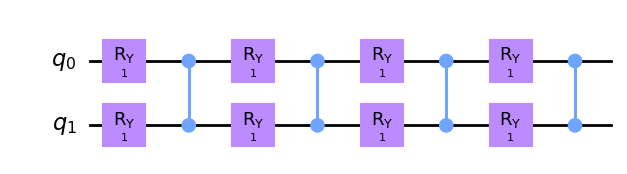

In [3]:
ansatz_param = None

def create_ansatz(circuit, qubit_list, layers):
    param_idx = 0
    for i in range(len(qubit_list)):
        circuit.ry(ansatz_param[param_idx], qubit_list[i])
        param_idx += 1
    for _ in range(layers):
        circuit.cz(qubit_list[0], qubit_list[1])
        circuit.cz(qubit_list[0], qubit_list[2])
        circuit.cz(qubit_list[1], qubit_list[2])
        for i in range(len(qubit_list)):
            circuit.ry(ansatz_param[param_idx], qubit_list[i])
            param_idx += 1

In [4]:
def get_submatrix(elm):
    matrix_list = []
    for k in range(len(elm)):
        if elm[k] == 'I':
            mat = I
        elif elm[k] == 'X':
            mat = X
        elif elm[k] == 'Y':
            mat = Y
        else:
            mat = Z
        matrix_list.append(mat)
    sub_matrix = np.kron(np.kron(matrix_list[0], matrix_list[1]),matrix_list[2])
    return sub_matrix
    

c = []

I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

#matrix_array = ['III','IIX','IIY','IIZ','IXX','IXY','IXZ','IYX','IYZ','IYY','IZX','IZY','IZZ','XII','XIX','XIY']

primitive = ['I','X','Y','Z']
matrix_array = []
for i in range(4):
    for j in range(4):
        for k in range(4):
            el = primitive[i] + primitive[j] + primitive[k]
            matrix_array.append(el)
    
print(matrix_array)


A = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        if i == j:
            A[i,j] = 6
        elif i == j+1 or i == j-1:
            A[i,j] = -4
        elif i == j+2 or i == j-2:
            A[i,j] = 1
        else:
            pass

A[0,0] = 5
A[7,7] = 5

res = np.zeros((8,8))
# To find the co-efficient list
for element in matrix_array:
    Al = get_submatrix(element)
    coef = (1/8) * np.trace(Al @ A)
    c.append(coef)
    res = res + coef * Al

print(c)
print(res.real)

['III', 'IIX', 'IIY', 'IIZ', 'IXI', 'IXX', 'IXY', 'IXZ', 'IYI', 'IYX', 'IYY', 'IYZ', 'IZI', 'IZX', 'IZY', 'IZZ', 'XII', 'XIX', 'XIY', 'XIZ', 'XXI', 'XXX', 'XXY', 'XXZ', 'XYI', 'XYX', 'XYY', 'XYZ', 'XZI', 'XZX', 'XZY', 'XZZ', 'YII', 'YIX', 'YIY', 'YIZ', 'YXI', 'YXX', 'YXY', 'YXZ', 'YYI', 'YYX', 'YYY', 'YYZ', 'YZI', 'YZX', 'YZY', 'YZZ', 'ZII', 'ZIX', 'ZIY', 'ZIZ', 'ZXI', 'ZXX', 'ZXY', 'ZXZ', 'ZYI', 'ZYX', 'ZYY', 'ZYZ', 'ZZI', 'ZZX', 'ZZY', 'ZZZ']
[5.75, -4.0, 0j, 0.0, 1.0, -2.0, 0j, 0.0, 0j, 0j, (-2+0j), 0j, 0.0, 0.0, 0j, -0.25, 0.0, 0.0, 0j, 0.0, 0.5, -1.0, 0j, 0.0, 0j, 0j, (1+0j), 0j, 0.0, 0.0, 0j, 0.0, 0j, 0j, 0j, 0j, 0j, 0j, (-1+0j), 0j, (0.5+0j), (-1+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0.0, 0.0, 0j, -0.25, 0.0, 0.0, 0j, 0.0, 0j, 0j, 0j, 0j, -0.25, 0.0, 0j, 0.0]
[[ 5. -4.  1.  0.  0.  0.  0.  0.]
 [-4.  6. -4.  1.  0.  0.  0.  0.]
 [ 1. -4.  6. -4.  1.  0.  0.  0.]
 [ 0.  1. -4.  6. -4.  1.  0.  0.]
 [ 0.  0.  1. -4.  6. -4.  1.  0.]
 [ 0.  0.  0.  1. -4.  6. -4.  1.]
 [ 0.  0.  0.  0.  1. 

In [5]:
subs = []
coef = []
for i in range(len(matrix_array)):
    if c[i].real != 0.0 or c[i].imag != 0.0:
        subs.append(matrix_array[i])
        coef.append(c[i].real)
c = coef
matrix_array = subs
print(c)
print(matrix_array)

[5.75, -4.0, 1.0, -2.0, -2.0, -0.25, 0.5, -1.0, 1.0, -1.0, 0.5, -1.0, -0.25, -0.25]
['III', 'IIX', 'IXI', 'IXX', 'IYY', 'IZZ', 'XXI', 'XXX', 'XYY', 'YXY', 'YYI', 'YYX', 'ZIZ', 'ZZI']


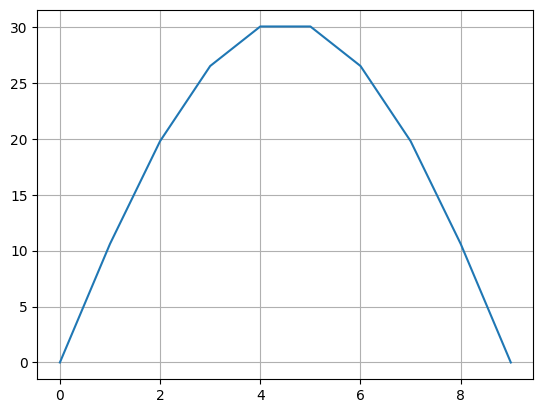

In [7]:
b = np.ones(8)/np.sqrt(8)
w = np.linalg.solve(A,b)
sol = np.zeros(10)
for i in range(8):
    sol[i+1] = w[i]
plt.plot(sol)
plt.grid()
plt.show()

## Generate Input Matrix

The input matrix from the Finite Difference Method Approximation can be decomposed as follows:
\begin{equation}
A = 5.5I_1I_2 - 4I_1X_2 - 2X_1X_2 - 2Y_1Y_2 - X_1I_2 - 0.5Z_1Z_2
\end{equation}

In [8]:
def create_A(circuit, idx):
    matrix = matrix_array[idx]
    q = 1
    for ele in matrix:
        if ele == 'X':
            circuit.cx(0,q)
        elif ele == 'Y':
            circuit.cy(0,q)
        elif ele == 'Z':
            circuit.cz(0,q)
        else:
            pass
        q += 1


def create_A_dagger(circuit, idx):
    create_A(circuit, idx)

## Create the Cost Function

Here, we go with the method of local cost functions:
\begin{equation}
C_L = \langle \psi|H_L|\psi\rangle
\end{equation}
This is done by computing the local Hamiltonians for each combination of the polynomial decomposition of the matrix A, as given by:
\begin{equation}
C_L = \frac{1}{2} - \frac{1}{2n}\frac{\sum_{l=0}^{m}\sum_{lp=0}^{m}\langle b|A_lA_{lp}^{\dagger}|\psi\rangle}{\sum_{l=0}^{m}\sum_{lp=0}^{m}\langle\psi|A_lA_{lp}^{\dagger}|\psi\rangle}
\end{equation}
where $n$ is the number of qubits required to approximate the solution.

In [9]:
# Specify parameters
shots = 50000
backend = Aer.get_backend('qasm_simulator')
noise_model = None
n_qubit = np.log2(len(b))
n_qubit = int(n_qubit)

# Create the function to evaluate the denominator of the Hadamard Test
def denom_Hadamard(l,lp,part='Re'):
    quantum_circuit = QuantumCircuit(n_qubit+1,1)
    quantum_circuit.h(0)
    
    if part == 'Im':
        quantum_circuit.sdg(0)
    
    create_ansatz(quantum_circuit, [i+1 for i in range(n_qubit)], layer)
    create_A(quantum_circuit,l)
    create_A_dagger(quantum_circuit,lp)

    quantum_circuit.h(0)
    quantum_circuit.measure(0,0)

    job = execute(quantum_circuit, backend=backend, shots=shots, noise_model=noise_model)
    result = job.result().get_counts()

    try:
        P0 = result["0"]
        P1 = shots - P0
    except:
        P1 = shots
        P0 = 0
    
    beta_denom = (P0 - P1)/shots
    return beta_denom

# Create the function to evaluate the numerator of the Hadamard Test
def numer_Hadamard(l,lp,j,part="Re"):
    quantum_circuit = QuantumCircuit(n_qubit+1,1)
    quantum_circuit.h(0)

    if part == "Im":
        quantum_circuit.sdg(0)
    
    create_ansatz(quantum_circuit, [i+1 for i in range(n_qubit)], layer)
    create_A(quantum_circuit, l)
    create_b_dagger(quantum_circuit, [i+1 for i in range(n_qubit)])
    quantum_circuit.cz(0,j)
    create_b(quantum_circuit, [i+1 for i in range(n_qubit)])
    create_A_dagger(quantum_circuit, lp)

    quantum_circuit.h(0)
    quantum_circuit.measure(0,0)

    job = execute(quantum_circuit,backend=backend, shots=shots, noise_model=noise_model)
    result = job.result().get_counts()

    try:
        P0 = result["0"]
        P1 = shots - P0
    except:
        P1 = shots
        P0 = 0
    
    delta_num = (P0 - P1)/shots
    return delta_num

# Create the function for the classical evaluation of the cost function
def cost_function(ansatz_param_updated):
    global ansatz_param, iteration

    ansatz_param = ansatz_param_updated
    num_sum = 0
    denom_sum = 0
    
    #start = time.time()

    for l in range(len(c)):
        for lp in range(len(c)):
            denom_sum += (c[l] * np.conj(c[lp]) * denom_Hadamard(l,lp,"Re"))
            for j in range(1,n_qubit+1):
                num_sum += (c[l] * np.conj(c[lp]) * numer_Hadamard(l,lp,j,"Re"))
    
    x = 0.5 - 0.5*num_sum/(n_qubit * denom_sum)
    #x = 1 - num_sum*num_sum/denom_sum
    x = abs(x)
    
    #end = time.time()
    
    #print(f'Iteration: {iteration}\tCost Function: {x}\tExecution Time: {end - start}')
    #time_list.append(end - start)
    print(f'Iteration: {iteration}\tCost Function: {x}')
    cost_list.append(x)
    iteration += 1
    return x

In [10]:
layer = 10
parameter_number = (layer + 1)*n_qubit
theta0 = np.random.normal(0, np.pi/2, parameter_number)
#theta0 = [random.random()*2*np.pi for i in range(layer*n_qubit + 2)]
cost_list = []
iteration = 1
minimize(cost_function, x0=theta0, args=(), method='Powell', tol=1e-4, options={'maxiter':1000})

Iteration: 1	Cost Function: 0.7370497079708208
Iteration: 2	Cost Function: 0.7357260094292621
Iteration: 3	Cost Function: 0.6699846472074865
Iteration: 4	Cost Function: 0.7190509066335616
Iteration: 5	Cost Function: 0.6502964980347463
Iteration: 6	Cost Function: 0.6559625594852835
Iteration: 7	Cost Function: 0.649478612620168
Iteration: 8	Cost Function: 0.6505155680193724
Iteration: 9	Cost Function: 0.6488921987382812
Iteration: 10	Cost Function: 0.6503509467374005
Iteration: 11	Cost Function: 0.6509474683839295
Iteration: 12	Cost Function: 0.6499763694204364
Iteration: 13	Cost Function: 0.4868698769312428
Iteration: 14	Cost Function: 0.4585031129571552
Iteration: 15	Cost Function: 0.4304907694411394
Iteration: 16	Cost Function: 0.4320563627786093
Iteration: 17	Cost Function: 0.4387209008438017
Iteration: 18	Cost Function: 0.4275433846549921
Iteration: 19	Cost Function: 0.42845123179049704
Iteration: 20	Cost Function: 0.4299055152247061
Iteration: 21	Cost Function: 0.42871143808208784


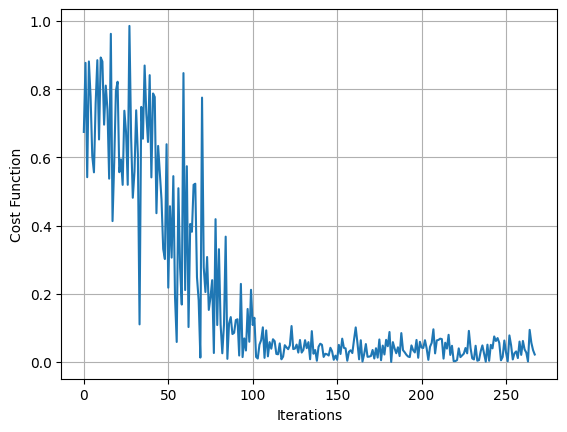

In [ ]:
#np.savetxt('Opt_Parameters_Euler.txt', ansatz_param)
plt.plot(cost_list)
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.grid()
plt.show()

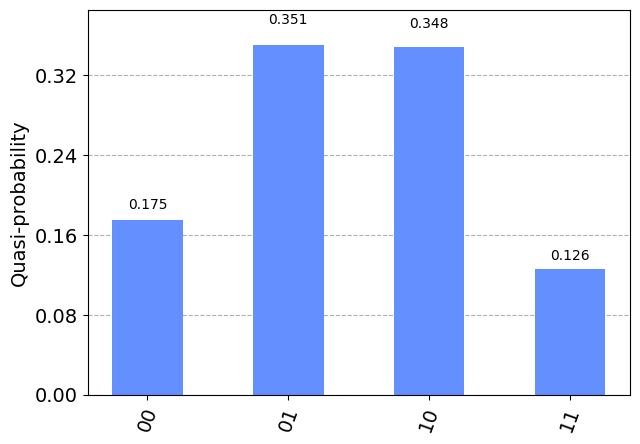

In [ ]:
qc_final = QuantumCircuit(n_qubit)
create_ansatz(qc_final, [0,1], layer)
qc_final.measure_all()
job = execute(qc_final, backend=backend, shots=100*shots, noise_model=noise_model)
results = job.result().get_counts()
for key in results:
    results[key] *= (0.01/shots)
plot_histogram(results)

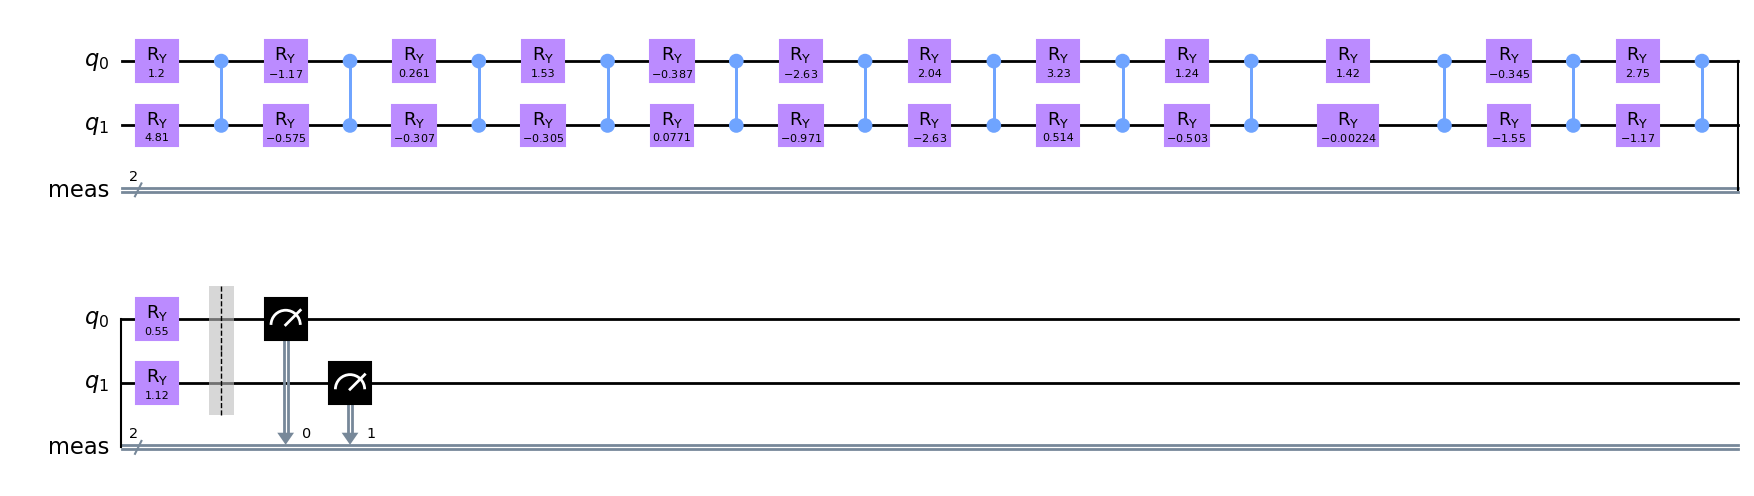

In [ ]:
qc_final.draw('mpl')